# Load Packages

In [ ]:
#%%script echo install only once
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 5.3 MB/s 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from hmmlearn import hmm

# Project

This project is centered around the observations you had generated from your own Markov model, during an earlier part of the course.

**Presentations (5 min)**:

Each group should give a brief presentation of their HMM story, if they have one - minimally they should communicate the number of states. 

No need to communicate any specific probabilities -- but listen carefully, sometimes the story may suggest prior information or constraints on emissions and transitions. This could be valuable during the learning.

**Exchange files**:

Exchange the files between the groups and try to infer the parameters used.

If the file has been written properly you should be able to read it like this

In [4]:
fn="obs_group3.txt"             # include the proper path in filename 

with open(fn, "r") as f:
    line  = f.readline().split()  # read first line and split
X = list(map(np.int64, line))   # map line to np.int64
X = np.array(X).reshape(-1,1)   # enforce proper shape: (T, 1)

print('Read',fn, 'with shape', X.shape)

Read obs_group3.txt with shape (10001, 1)


# First Inspection

Inspect $X$ and make sure you the data is properly formatted

How long is $X$? What is the number of unique observations? It might be a good idea to plot a histogram 

(array([6503., 1038., 2460.]), array([0, 1, 2, 3]), <BarContainer object of 3 artists>)


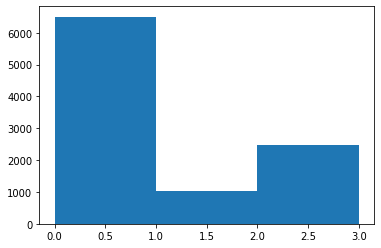

In [18]:
len(X)
print(plt.hist(X,bins=[0,1,2,3]))



If - later on - you want to exchange general objects (such as models) among yourself you might want to use *pickle*

In [ ]:
import pickle
fn = "my_best_model.obj"  # chose a meaningful name
fh = open(fn,"wb")
pickle.dump(best_model,fh)
fh.close()

fh = open(fn,'rb')
b_model = pickle.load(fh)
fh.close()

# Fit

Now you are ready to go.
Fit the model - and try to optimize the score as much as you (and the Baum-Welch algorithm) can.

In [28]:
from matplotlib.colors import Normalize

def HMM_inspect(Z,X,t=50):
  z_str = ''.join(str(z) for z in Z.flatten()[0:t])
  x_str = ''.join(str(x) for x in X.flatten()[0:t])
  print('Z: ',z_str)
  print('X: ',x_str)

  bs=list(np.arange(0,6,0.5))
  plt.hist(X[Z == 0], label='Z=0', alpha=0.5, bins=bs)
  plt.hist(X[Z == 1], label='Z=1', alpha=0.5, bins=bs)
  plt.xlabel('observation X')
  plt.legend()
  plt.show()

# plot matrix (with title and numbers)
def plotMatrix(ax, mat, title, cm, normalizer):
  ax.imshow(mat, cmap=cm, norm=normalizer)
  for (j,i),label in np.ndenumerate(mat):
    ax.text(i,j,np.round(label,2),ha='center',va='center')
    ax.set_title(title)

def compareHMM(model, model_fit):
  ## Visualization ###
  my_cm=plt.cm.Blues        # set color-map
  normalizer=Normalize(0,1) # set common color code for trans and emission probs 

  fig, ax = plt.subplots(3, 2, 
      gridspec_kw={'width_ratios': [1, 3], 'height_ratios': [1, 1, 0.1]},
      figsize=(10,7))

  plotMatrix(ax[0,0], model.transmat_, 'trans - orig', my_cm, normalizer)
  plotMatrix(ax[0,1], model.emissionprob_, 'emissions - orig', my_cm, normalizer)
  plotMatrix(ax[1,0], model_fit.transmat_, 'trans - fit', my_cm, normalizer)
  plotMatrix(ax[1,1], model_fit.emissionprob_, 'emissions - fit', my_cm, normalizer)

  # add colorbar with common color scale (set by im)
  im = plt.cm.ScalarMappable( cmap=my_cm, norm=normalizer) 
  fig.colorbar(im, cax=ax[2,0], orientation='horizontal')
  fig.colorbar(im, cax=ax[2,1], orientation='horizontal')
  plt.show()

best_first_score -8600.713371012831
best_score -8292.430672072032
Z:  10000000000001110000000000000000000000000000000000
X:  20000110010012120020000100000002020102001000200100


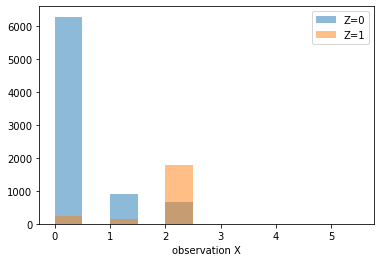

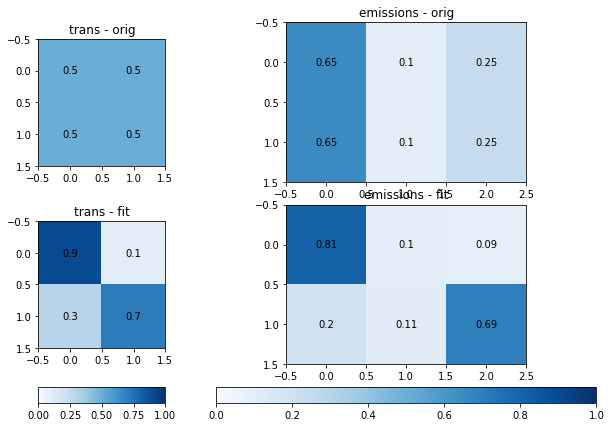

ConvergenceMonitor(
    history=[-9132.734529537636, -8590.550158979353, -8580.061729532654, -8568.341507160385, -8554.498708103372, -8537.688659409041, -8517.236648653676, -8492.925979449785, -8465.3891063686, -8436.336291935437, -8408.24131658789, -8383.43430369381, -8363.206321555608, -8347.626930796232, -8336.031073424138, -8327.577495087256, -8321.518081440525, -8317.240052924875, -8314.245604237945, -8312.139629126792, -8310.62406555105, -8309.487140398804, -8308.586379371034, -8307.830054396036, -8307.161071163117, -8306.544824397162, -8305.960828477355, -8305.397268861587, -8304.847579480527, -8304.308339150373, -8303.777994777982, -8303.256091326846, -8302.742808148876, -8302.238679247796, -8301.744423498716, -8301.260840589664, -8300.78874632376, -8300.328931740993, -8299.882136747274, -8299.449032923041, -8299.03021225785, -8298.626179988576, -8298.237350377014, -8297.864044805372, -8297.506491690714, -8297.164827977862, -8296.839101937647, -8296.52927707574, -8296.235236997

In [38]:
#%%script echo edit before execution


N_ini = 1
N_iter = 1000
P_assumed = np.array([ [0.9, 0.1],
                       [0.1, 0.9] ])

E_assumed = np.array([ [0.75, 0.125, 0.125],
                       [0.33, 0.33, 0.34] ])
np.random.seed(42)
#first_model = hmm.MultinomialHMM(n_components=2, n_iter=1, init_params='ste')
#first_model.fit(X)

best_first_model = None
best_first_score = -1e81

for i in range(30):
    curr_model = hmm.MultinomialHMM(n_components=2, n_iter=1000, init_params='st') # as a default it randomizes all matrices
    # if we set init_params to 'se' we can now use:
    # curr_model.transmat_ = P_assumed # to set where to start the search for the transitin matrix
#    curr_model.transmat_ = P_assumed
    curr_model.emissionprob_ = np.array( [ [1/3, 1/3, 1/3],
                                           [1/3, 1/3, 1/3] ])
    curr_model.fit(X)
    curr_score = curr_model.score(X)
    if curr_score > best_first_score:
        best_first_score = curr_score
        best_first_model = curr_model



best_score = -1e81 # something really small
best_model = None
        
for i in range(30):
    curr_model = hmm.MultinomialHMM(n_components=2, n_iter=1000, init_params='st') # as a default it randomizes all matrices
    # if we set init_params to 'se' we can now use:
    # curr_model.transmat_ = P_assumed # to set where to start the search for the transitin matrix
#    curr_model.transmat_ = P_assumed
    curr_model.emissionprob_ = E_assumed
    curr_model.fit(X)
    curr_score = curr_model.score(X)
    if curr_score > best_score:
        best_score = curr_score
        best_model = curr_model


print(f'best_first_score {best_first_score}')
print(f'best_score {best_score}')
_,Zv = best_model.decode(X)
HMM_inspect(Zv,X)
compareHMM(best_first_model, best_model)

curr_model.monitor_


#_,Zv = best_model.decode(X)

best_score -8585.607581952847


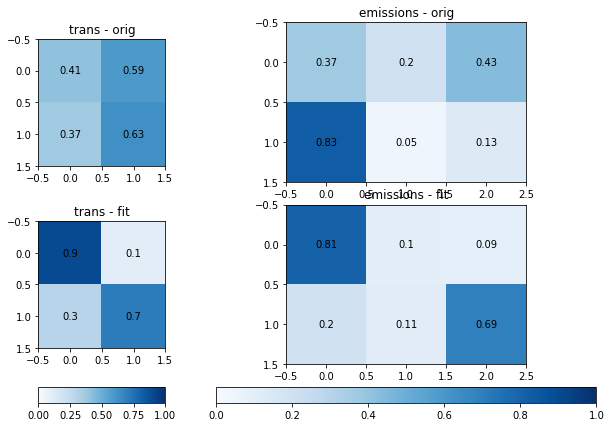

In [41]:
np.random.seed(42)
random_model = hmm.MultinomialHMM(n_components=2, n_iter=1, init_params='ste')
random_model.fit(X)
print(f'best_score {random_model.score(X)}')
compareHMM(random_model, best_model)

# Presentation

Present your efforts and the resulting transition and emission probabilities. Maybe you want to compare several models.

(You might want to utilize some visualizations from the previous lecture)

In [ ]:
# some convenience functions
from matplotlib.colors import Normalize

# plot matrix (with title and numbers)
def plotMatrix(ax, mat, title, cm, normalizer):
  ax.imshow(mat, cmap=cm, norm=normalizer)
  for (j,i),label in np.ndenumerate(mat):
    ax.text(i,j,np.round(label,2),ha='center',va='center')
    ax.set_title(title)

# compare two models
def compareHMM(model, model_fit):
  ## Visualization ###
  my_cm=plt.cm.Blues        # set color-map
  normalizer=Normalize(0,1) # set common color code for trans and emission probs 

  fig, ax = plt.subplots(3, 2, 
      gridspec_kw={'width_ratios': [1, 3], 'height_ratios': [1, 1, 0.1]},
      figsize=(10,7))

  plotMatrix(ax[0,0], model.transmat_, 'trans - orig', my_cm, normalizer)
  plotMatrix(ax[0,1], model.emissionprob_, 'emissions - orig', my_cm, normalizer)
  plotMatrix(ax[1,0], model_fit.transmat_, 'trans - fit', my_cm, normalizer)
  plotMatrix(ax[1,1], model_fit.emissionprob_, 'emissions - fit', my_cm, normalizer)

  # add colorbar with common color scale (set by im)
  im = plt.cm.ScalarMappable( cmap=my_cm, norm=normalizer) 
  fig.colorbar(im, cax=ax[2,0], orientation='horizontal')
  fig.colorbar(im, cax=ax[2,1], orientation='horizontal')
  plt.show()

In [ ]:
compareHMM(best_model,b_model)